In [1]:
WEIGHTS_V = 20

# **Data Preprocessing**

## *Select Classes*

In [2]:
import pandas as pd

In [3]:
data_path = "..\Datasets\AUTSL"

train_labels = pd.read_csv(os.path.join(data_path,"labels\\train_labels.csv"),names=['sample','id'])
validation_labels = pd.read_csv(os.path.join(data_path,"labels\\val_labels.csv"),names=['sample','id'])
test_labels = pd.read_csv(os.path.join(data_path,"labels\\test_labels.csv"),names=['sample','id'])
class_id = pd.read_csv(os.path.join(data_path,"labels\\class_id.csv"))


    
train_path = os.path.join(data_path,"train")
val_path = os.path.join(data_path,"val")
test_path = os.path.join(data_path,"test")

In [4]:
def check_file(file_path):
    try:
        f = open(file_path)
        f.close()
        return True
    except IOError:
        return False
    
def construct_path(file,path="train"):
    return os.path.join(os.path.join(data_path,path),file+"_color.mp4")

In [5]:
n_classes = 226
actions = list(class_id['EN'][:n_classes])
dic={}
for i,action in enumerate(actions):
    dic[action]=i

In [6]:
def get_data(id,file_path):
    if file_path=="train":
        label_dic = train_labels
    elif file_path=="val":
        label_dic = validation_labels
    elif file_path=="test":
        label_dic = test_labels
        
    
    data =  label_dic[label_dic['id']==id]
    lis =  [construct_path(i,file_path) for i in  (data['sample'])]
    data =  [i for i in lis if check_file(i)]
    return data,[id for i in data]

In [7]:
train_X = [] 
train_Y = []
val_X = [] 
val_Y = []
test_X = [] 
test_Y = []

for i in range(n_classes):
    data,labels = get_data(i,'train')
    train_X.extend(data)
    train_Y.extend(labels)

    
for i in range(n_classes):
    data,labels = get_data(i,'val')
    val_X.extend(data)
    val_Y.extend(labels)

    
for i in range(n_classes):
    data,labels = get_data(i,'test')
    test_X.extend(data)
    test_Y.extend(labels)

In [8]:
video_path = train_X[0]
def_input_path = "..\\Datasets\\AUTSL\\train\\"
video_path[len(def_input_path):-4]

'signer0_sample431_color'

## *Prepare Videos*

In [9]:
import os
import cv2
import numpy as np

In [10]:
def get_frames(video_path, n_frames=1):
    frames = []
    v_cap = cv2.VideoCapture(video_path)
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT)) + 1
    frame_list = np.linspace(0, v_len-1, n_frames+1, dtype=np.int16)

    for fn in range(60):
        success, frame = v_cap.read()
        if success == False:
            continue
        if fn in frame_list:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    v_cap.release()
    return frames, v_len

def store_frames(frames, path_to_store):
    for i, frame in enumerate(frames):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        path = os.path.join(path_to_store, "frame"+str(i)+".jpg")
        cv2.imwrite(path, frame)


In [11]:
def get_paths(folder, output_path_only=False):
    # output_path: path to store video's frames "train, val, test"
    # input_path: path that contains dataset folders "train, val, test"
    output_path = f"D:\College\TERM 7\Graduation Project - 1\SLR\prepared dataset\\{folder}"
    if output_path_only:
        return output_path
    def_input_path = f"..\\Datasets\\AUTSL\\{folder}\\"
    return def_input_path, output_path

folders = ["train", "val", "test"]
for folder in folders:
    def_input_path, output_path = get_paths(folder)
    working_list_X = None
    working_list_Y = None
    if folder == "train":
        working_list_X = train_X
        working_list_Y = train_Y
    elif folder == "val":
        working_list_X = val_X
        working_list_Y = val_Y
    else:
        working_list_X = test_X
        working_list_Y = test_Y
    
    size = len(working_list_X)    
    for i in range(size):
        video_path = working_list_X[i]
        label = working_list_Y[i]
        working_list_X[i] = working_list_X[i][len(def_input_path):-4]
        video_name = video_path[len(def_input_path):-4]
        path_to_store = os.path.join(output_path, str(label))
        if not os.path.exists(path_to_store):
            os.mkdir(path_to_store)
        path_to_store = os.path.join(path_to_store, video_name)
        if not os.path.exists(path_to_store):
            os.mkdir(path_to_store)
            frames, v_len = get_frames(video_path, n_frames=16)
            store_frames(frames=frames, path_to_store=path_to_store)

    

# **Dataset**

## *Build Dataset Class*

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import random

In [13]:
import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [14]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)        
    return x

In [15]:
np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)

class VideoDataset(Dataset):
    def __init__(self, imgs_name, labels, folder="train", transform = None):
        super(VideoDataset, self).__init__()
        self.labels = labels
        self.transform = transform

        input_path = get_paths(folder=folder, output_path_only=True)
        self.imgs_path = []
        for img_name, label in zip(imgs_name, labels):
            img_path = os.path.join(input_path, str(label))
            img_path = os.path.join(img_path, img_name)
            self.imgs_path.append(img_path)
    
    def __len__(self):
        return len(self.imgs_path)

    def __getitem__(self, idx):
        imgs = os.listdir(self.imgs_path[idx])
        imgs = sorted_alphanumeric(imgs)
        frames = []
        for img in imgs:
            img_path = os.path.join(self.imgs_path[idx], img)
            frame = Image.open(img_path)
            frames.append(frame)
        
        seed = np.random.randint(1e9)
        if self.transform:
            for i in range(len(frames)):
                random.seed(seed)
                np.random.seed(seed)
                frames[i] = self.transform(frames[i])
        if len(frames) > 0:
            frames = torch.stack(frames)

        return frames, self.labels[idx]


# **Models**

## *Utils*

In [16]:
import copy

In [17]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [18]:
def metrics_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

In [19]:
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    with torch.no_grad():
        metric_b = metrics_batch(output, target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b

In [20]:
def loss_epoch(model, loss_func, dataset_dl, opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data = len(dataset_dl.dataset)
    for xb, yb in dataset_dl:
        xb=xb.to(device)
        yb=yb.to(device)
        model = model.to(device)
        output=model(xb)
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b
    
    loss = running_loss/float(len_data)
    metric = running_metric/float(len_data)
    return loss, metric

In [21]:
def train_val(model, num_epochs, loss_func, opt, train_dl, val_dl, lr_scheduler, path_to_weights):   
    loss_history={
        "train": [],
        "val": [],
    }
    
    metric_history={
        "train": [],
        "val": [],
    }
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')
    
    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, opt)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path_to_weights)
            print("Copied best model weights!")
        
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts)
        
        print("train loss: %.6f, train_accuracy: %.2f, val_loss: %.6f, val_accuracy: %.2f" %(train_loss, 100*train_metric, val_loss, 100*val_metric))
        print("-"*10) 
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [22]:
def plot_loss(loss_hist, metric_hist):

    num_epochs= len(loss_hist["train"])

    plt.title("Train-Val Loss")
    plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
    plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
    plt.ylabel("Loss")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

    plt.title("Train-Val Accuracy")
    plt.plot(range(1,num_epochs+1), metric_hist["train"],label="train")
    plt.plot(range(1,num_epochs+1), metric_hist["val"],label="val")
    plt.ylabel("Accuracy")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

## *Build Models*

#### *1. Resnet + RNN*

In [23]:
import torch.nn as nn
import torchvision

In [24]:
class Resnt18Rnn(nn.Module):
    def __init__(self, num_classes, dr_rate, pretrained, rnn_hidden_size, rnn_num_layers):
        super(Resnt18Rnn, self).__init__()
        baseModel = torchvision.models.resnet18(pretrained=pretrained)
        num_features = baseModel.fc.in_features
        baseModel.fc = Identity()
        self.baseModel = baseModel
        self.dropout= nn.Dropout(dr_rate)
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
    def forward(self, x):
        b_z, ts, c, h, w = x.shape
        ii = 0
        y = self.baseModel((x[:,ii]))
        output, (hn, cn) = self.rnn(y.unsqueeze(1))
        for ii in range(1, ts):
            y = self.baseModel((x[:,ii]))
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))
        out = self.dropout(out[:,-1])
        out = self.fc1(out) 
        return out 
    
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x    

# **Implementation**

## *Create training, validation, testing datasets*

In [25]:
model_type = "3dcnn"
# model_type = "rnn"

if model_type == "rnn":
    h, w =224, 224
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
else:
    h, w = 128, 128
    mean = [0.43216, 0.394666, 0.37645]
    std = [0.22803, 0.22145, 0.216989]

In [26]:
import torchvision.transforms as transforms

In [27]:
train_transformer = transforms.Compose([
                        transforms.Resize((h, w)),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean, std)
                        ])


train_ds = VideoDataset(imgs_name=train_X, labels=train_Y, folder="train", transform=train_transformer)
len(train_ds)

28142

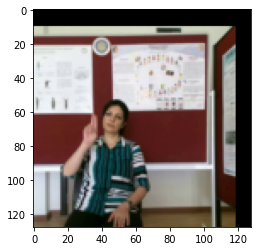

In [28]:
imgs, label = train_ds[0]
plt.imshow(denormalize(imgs[10], mean, std))

In [29]:
val_transofrmer = transforms.Compose([
                        transforms.Resize((h, w)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean, std)
                        ])

val_ds = VideoDataset(imgs_name=val_X, labels=val_Y, folder="val", transform=val_transofrmer)
len(val_ds)

4418

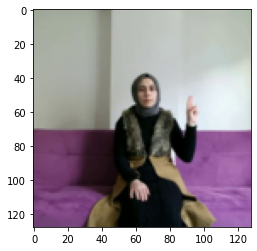

In [30]:
imgs, label = val_ds[10]
plt.imshow(denormalize(imgs[10], mean, std))

In [31]:
test_transformer = transforms.Compose([
                        transforms.Resize((h, w)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean, std)
                        ])

test_ds = VideoDataset(imgs_name=test_X, labels=test_Y, folder="test", transform=test_transformer)
len(test_ds)

3742

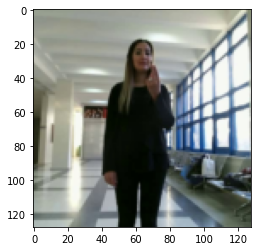

In [32]:
imgs, label = test_ds[10]
plt.imshow(denormalize(imgs[10], mean, std))

## *Create training, validation, testing dataloaders*

In [33]:
def collate_fn_r3d_18(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    imgs_tensor = torch.transpose(imgs_tensor, 2, 1)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor, labels_tensor

def collate_fn_rnn(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor

batch_size = 1
if model_type == "rnn":
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_rnn)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_rnn)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_rnn)
else:
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_r3d_18)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_r3d_18)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_r3d_18)

In [34]:
for xb, yb in train_dl:
    print(xb.shape, yb.shape, yb[0])
    break

for xb, yb in val_dl:
    print(xb.shape, yb.shape, yb[0])
    break

for xb, yb in test_dl:
    print(xb.shape, yb.shape, yb[0])
    break

torch.Size([1, 3, 16, 128, 128]) torch.Size([1]) tensor(162)
torch.Size([1, 3, 15, 128, 128]) torch.Size([1]) tensor(0)
torch.Size([1, 3, 16, 128, 128]) torch.Size([1]) tensor(0)


## *Testing the model*

In [35]:
import pytorchvideo.models.resnet as resnet
import torch.nn as nn

if model_type == "rnn":
        params_model={
                "num_classes": n_classes,
                "dr_rate": 0.1,
                "pretrained" : True,
                "rnn_num_layers": 1,
                "rnn_hidden_size": 100,
                }
        model = Resnt18Rnn(**params_model)
else:
        # model = torchvision.models.video.r2plus1d_18(pretrained=True, progress=False)
        # num_features = model.fc.in_features
        # model.fc = nn.Linear(num_features, n_classes)

        model = resnet.create_resnet(input_channel=3,
                                model_depth=50,
                                model_num_class=n_classes,
                                norm=nn.BatchNorm3d,
                                activation=nn.ReLU)

model

VideoResNet(
  (stem): R2Plus1dStem(
    (0): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
    (1): BatchNorm3d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv2Plus1D(
          (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
          (1): BatchNorm3d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
        )
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [36]:
with torch.no_grad():
    if model_type == "rnn":
        x = torch.zeros(1, 16, 3, h, w)
    else:
        x = torch.zeros(1, 3, 16, h, w)
    y = model(x)
    print(y.shape)

torch.Size([1, 226])


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [38]:
path_to_weights = ".\weights\weights.pt"
torch.save(model.state_dict(), path_to_weights)

## *Model Training*

In [39]:
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

loss_fn = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=3e-5)
lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=5, verbose=1)
os.makedirs(".\models", exist_ok=True)

params_train = {
    "num_epochs": 100,
    "opt": opt,
    "loss_func": loss_fn,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "lr_scheduler": lr_scheduler,
    "path_to_weights": ".\models\weights_"+model_type+ "_v" + str(WEIGHTS_V) + ".pt"
}

In [43]:
checkpoint = {
                "last_epoch": 7,
                "best_epoch": 0,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": opt.state_dict(),
                "scheduler": lr_scheduler.state_dict(),
                "loss": loss_fn.state_dict(),
            }

torch.save(checkpoint, "cp.pt")

In [40]:
WEIGHTS_V += 1
torch.cuda.empty_cache()
model, loss_hist, metric_hist = train_val(model, **params_train)

Epoch 0/99, current lr=3e-05
Copied best model weights!
train loss: 5.450419, train_accuracy: 0.37, val_loss: 5.422030, val_accuracy: 0.34
----------
Epoch 1/99, current lr=3e-05
train loss: 5.429150, train_accuracy: 0.50, val_loss: 5.422134, val_accuracy: 0.36
----------
Epoch 2/99, current lr=3e-05
train loss: 5.347774, train_accuracy: 0.75, val_loss: 6.177265, val_accuracy: 0.57
----------
Epoch 3/99, current lr=3e-05
train loss: 5.309548, train_accuracy: 0.86, val_loss: 5.492731, val_accuracy: 0.63
----------
Epoch 4/99, current lr=3e-05
train loss: 5.281633, train_accuracy: 0.98, val_loss: 5.457896, val_accuracy: 0.79
----------
Epoch 5/99, current lr=3e-05
train loss: 5.265485, train_accuracy: 1.04, val_loss: 6.906144, val_accuracy: 0.45
----------
Epoch 6/99, current lr=3e-05
Epoch     7: reducing learning rate of group 0 to 1.5000e-05.
Loading best model weights!
train loss: 5.253364, train_accuracy: 0.94, val_loss: 5.644587, val_accuracy: 0.54
----------
Epoch 7/99, current lr

KeyboardInterrupt: 

In [ ]:
metric_hist

In [ ]:
plot_loss(loss_hist, metric_hist)

## *Model Testing*

#### 1. *Load pretrained weights*

In [ ]:
import torch

checkpoint = torch.load(".\models\weights_3dcnn.pt")

In [ ]:
model.load_state_dict(checkpoint)

#### 2. *Testing the model*

In [ ]:
loss_fn = nn.CrossEntropyLoss(reduction="sum")

params_test = {
    "model": model,
    "loss_func": loss_fn,
    "dataset_dl": test_dl
}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    testing_loss, testing_metric = loss_epoch(**params_test)

print("dev loss: %.6f, accuracy: %.2f" %(testing_loss,100*testing_metric))